In [3]:
# Importing Necessary Libraries

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression

import scipy
from scipy import stats

import statsmodels
import statsmodels.api as sm


In [4]:
#Moving Average Model

def MA(epsilon, theta, mean=0):
    theta = list(theta)
    N = len(epsilon)
    theta0 = np.array([1] + theta)
    theta0 = theta0[::-1] # Invert the order
    q = len(theta0)
    
    X = []
    for i in range(N-q):
        X.append(np.dot(theta0, epsilon[i:i+q])+mean)
    
    return np.array(X)

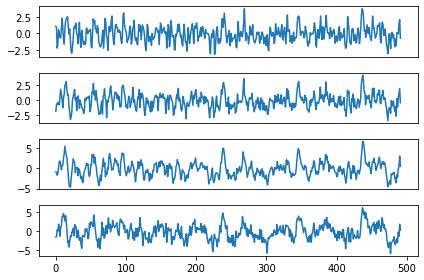

In [25]:
# Example for the Moving Average
N = 500
thetas = []
X_MA = []
q_max = 8

epsilon = np.random.normal(size=N)

for q in range(1, q_max+1, 2):
    thetas.append(np.random.random(q))
    X_MA.append(MA(epsilon, thetas[-1]))

fig, axs = plt.subplots(4, 1)

for i in range(q_max//2):
    axs[i].plot(X_MA[i])
    #axs[i].legend([r'$\theta=\left[%s\right]$' % ", ".join(thetas[i].round(2).astype('str'))], prop={'size': 14})
    axs[i].get_xaxis().set_visible(False)
    
axs[-1].get_xaxis().set_visible(True)
fig.tight_layout()

In [8]:
# Auto Correlation functions

def pearson(x, y):
    meanx = x.mean()
    meany = y.mean()
    stdx = x.std()
    stdy = y.std()
    return np.mean((x - meanx) * (y - meany)) / (stdx * stdy)

def acf(x, lag=40):
    return np.array([1] + [pearson(x[:-i], x[i:]) for i in range(1, lag)])

def acf_ci(acfv, n, alpha=0.05):
    se = [1 / np.sqrt(n)]
    se.extend(np.sqrt((1+2*np.cumsum(np.power(acfv[1:-1], 2)))/n))
    se = np.array(se)
    
    se *= stats.norm.ppf(1-alpha/2.)
    return se

def plot_acf(x, lag=40, alpha=0.05):
    acf_val = acf(x, lag)
    
    plt.vlines(range(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('ACF')
    
    # Determine confidence interval
    ci = acf_ci(acf_val, len(x), alpha)
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

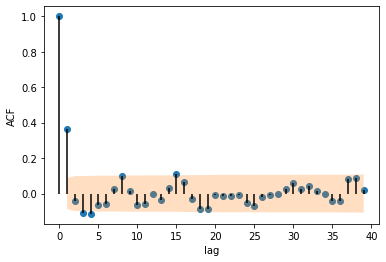

In [9]:
# Plotting the Auto Correlation graph for the above example

plot_acf(X_MA[0])

In [10]:
# Auto Regressive Model

def AR(epsilon, phi, drift=0):
    phi = list(phi)
    N = len(epsilon)

    phi0 = np.array([1] + phi)
    phi0 = phi0[::-1] # Invert the order
    p = len(phi0)
    
    X = epsilon.copy()

    for i in range(p, N):
        X[i-1] = np.dot(X[i-p:i], phi0) + drift
        
    return np.array(X)

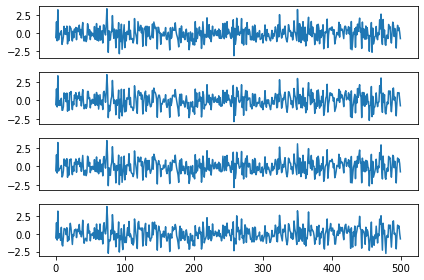

In [12]:
# Example for an Auto Regressive Model

N = 500
phis = []
X_AR = []
p_max = 8

epsilon = np.random.normal(size=N)

for p in range(1, p_max+1, 2):
    phis.append(np.random.normal(0, 0.1, p))
    X_AR.append(AR(epsilon, phis[-1]))

fig, axs = plt.subplots(4, 1)

for i in range(p_max//2):
    axs[i].plot(X_AR[i])
    #axs[i].legend([r'$\phi=\left[%s\right]$' % ", ".join(phis[i].round(2).astype('str'))], prop={'size': 14})
    axs[i].get_xaxis().set_visible(False)
    
axs[-1].get_xaxis().set_visible(True)

fig.tight_layout()

In [14]:
# Partial AutoCorrelation Functions

def rolling(x, order):
    npoints = x.shape[0]
    running = []
    
    for i in range(npoints-order):
        running.append(x[i:i+order])
        
    return np.array(running)

def pacf(x, lag=40):
    y = []
    
    for i in range(3, lag + 2):
        windows = rolling(x.flatten(), i)

        xt = windows[:, -1] # Current values are at the end
        xt_l = windows[:, 0] # Lagged values are at 0
        inter = windows[:, 1:-1] # Intermediate values are in between 1 and -1

        lm = LinearRegression(fit_intercept=False).fit(inter, xt)
        xt_fit = lm.predict(inter)

        lm = LinearRegression(fit_intercept=False).fit(inter, xt_l)
        xt_l_fit = lm.predict(inter)

        y.append(pearson(xt - xt_fit, xt_l - xt_l_fit))
    
    # Pad the array with the two missing values
    pacf_1 = acf(x, 2)[1]
    return np.array([1, pacf_1] +  y)

def plot_pacf(x, alpha=0.05, lag=40):
    pacf_val = pacf(x, lag)
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('PACF')
    
    # Determine confidence interval
    ci = acf_ci(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

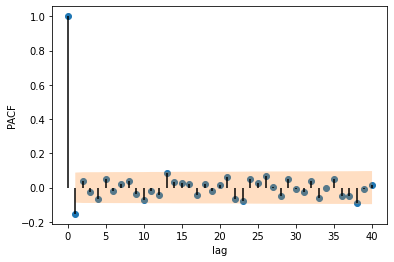

In [15]:
plot_pacf(X_AR[0])

In [16]:
# Combining the Auto Regressive and Moving Average Model to Create the ARIMA

def differentiate(values, d=1):
    # First value is required so that we can recover the original values with np.cumsum
    x = np.concatenate([[values[0]], values[1:]-values[:-1]])

    if d == 1:
        return x
    else:    
        return differentiate(x, d - 1)

def integrate(values, d=1):
    x = np.cumsum(values)
    
    if d == 1:
        return x
    else:
        
        return integrate(x, d-1)

class ARIMA(LinearRegression):
    def __init__(self, q, d, p):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        """
        super().__init__(True)
        self.p = p
        self.d = d
        self.q = q
        self.ar = None
        self.resid = None
        
    def prepare_features(self, x):
        if self.d > 0:
            x = differentiate(x, self.d)
                    
        ar_features = None
        ma_features = None
        
        # Determine the features and the epsilon terms for the MA process
        if self.q > 0:
            if self.ar is None:
                self.ar = ARIMA(0, 0, self.p)
                self.ar.fit_predict(x)
            eps = self.ar.resid
            eps[0] = 0
            
            # prepend with zeros as there are no residuals_t-k in the first X_t
            ma_features = rolling(np.r_[np.zeros(self.q), eps], self.q)
            
        # Determine the features for the AR process
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = rolling(np.r_[np.zeros(self.p), x], self.p)
                                
        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features)) 
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ar_features, ma_features))
        elif ma_features is not None: 
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]
        
        return features, x[:n]
    
    def fit(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return features
            
    def fit_predict(self, x): 
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        features = self.fit(x)
        return self.predict(x, prepared=(features))
    
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features = kwargs.get('prepared', None)
        if features is None:
            features, x = self.prepare_features(x)
        
        y = super().predict(features)
        self.resid = x - y

        return self.return_output(y)
    
    def return_output(self, x):
        if self.d > 0:
            x = integrate(x, self.d) 
        return x
    
    def forecast(self, x, n):
        """
        Forecast the time series.
        
        :param x: (array) Current time steps.
        :param n: (int) Number of time steps in the future.
        """
        features, x = self.prepare_features(x)
        y = super().predict(features)
        
        # Append n time steps as zeros. Because the epsilon terms are unknown
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            feat = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = super().predict(feat[None, :])
        return self.return_output(y)

In [19]:
ILI = pd.read_csv('/content/CDC.csv')
ILI['date'] = ILI['Year']+ILI['Week']/52.
values = ILI['Percent of Deaths Due to Pneumonia and Influenza'].values
diff = differentiate(values, 1)

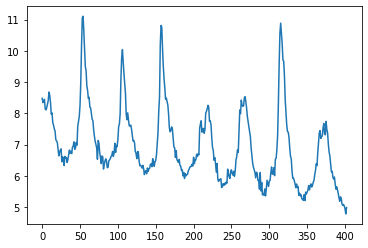

In [18]:
# Plotting the Actual Data
plt.plot(values)


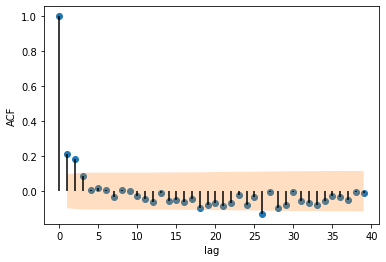

In [20]:
# Plotting the Auto Correllation Function
plot_acf(diff)

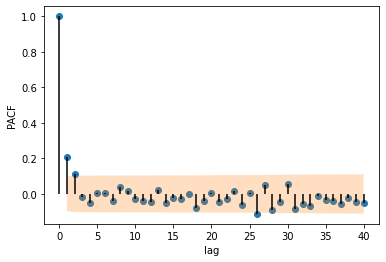

In [21]:
# Plotting the Partial Auto Correllation Function
plot_pacf(diff)

In [22]:
# Creating the Model

model = ARIMA(2, 0, 2)
pred = model.fit_predict(values)

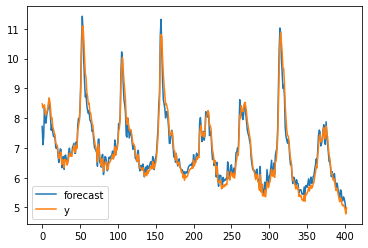

In [23]:
ax = plt.subplot(111)
ax.plot(pred[1:], label='forecast')
ax.plot(values, label='y')
plt.legend()

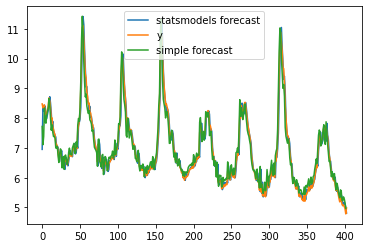

In [24]:
results = sm.tsa.ARIMA(values, (2, 0, 2)).fit()

fig, ax = plt.subplots(1, 1)
pred_sm = results.plot_predict(ax=ax)
ax.plot(pred[1:])
plt.legend(['statsmodels forecast', 'y', 'simple forecast'])